In [1]:
import cv2
import math
import matplotlib.pyplot as plt
net = cv2.dnn.readNet("./models/frozen_east_text_detection.pb")   #This is the model we get after extraction
frame = cv2.imread("./screens/01_bank-app.jpg")
inpWidth = inpHeight = 320  # A default dimension
# Preparing a blob to pass the image through the neural network
# Subtracting mean values used while training the model.
image_blob = cv2.dnn.blobFromImage(frame, 1.0, (inpWidth, inpHeight), (123.68, 116.78, 103.94), True, False)

In [2]:
output_layer = []
output_layer.append("feature_fusion/Conv_7/Sigmoid")
output_layer.append("feature_fusion/concat_3")

In [3]:
net.setInput(image_blob)
output = net.forward(output_layer)
scores = output[0]
geometry = output[1]

In [4]:
def decode(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

In [5]:
confThreshold = 0.5
nmsThreshold = 0.3
[boxes, confidences] = decode(scores, geometry, confThreshold)
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

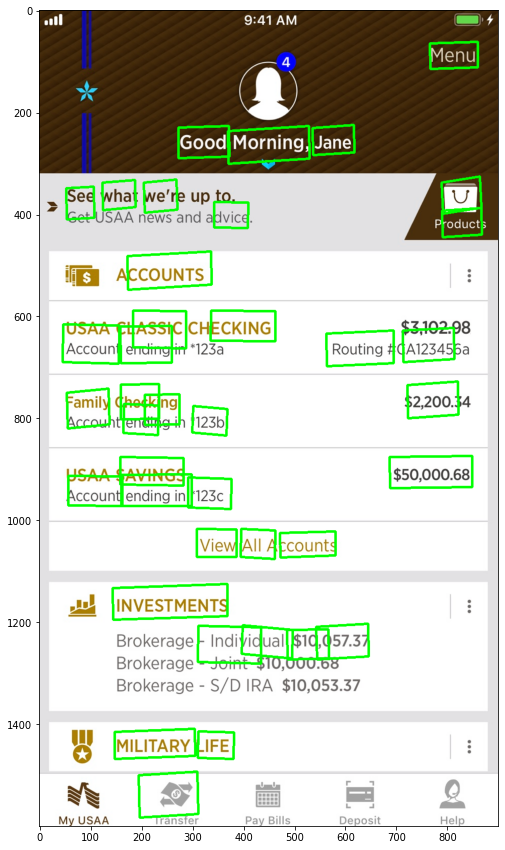

In [6]:
height_ = frame.shape[0]
width_ = frame.shape[1]
rW = width_ / float(inpWidth)
rH = height_ / float(inpHeight)

for i in indices:
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[i])
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    for j in range(4):
        p1 = (int(vertices[j][0]), int(vertices[j][1]))
        p2 = (int(vertices[(j + 1) % 4][0]), int(vertices[(j + 1) % 4][1]))
        cv2.line(frame, p1, p2, (0, 255, 0), 3)

# To save the image:
plt.figure(figsize = (15, 15))
plt.imshow(frame)